In [88]:
# forked from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [89]:
import numpy as np
import pandas as pd
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style("darkgrid")

from _utils.u_constant import PATH_ROOT
path = PATH_ROOT + "Code projects/Python/kaggle/House Prices Advanced Regression Techniques/"

In [90]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
print("the train size is: ", train.shape)
print("the test size is: ", test.shape)
train.head(5)

the train size is:  (1460, 81)
the test size is:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [91]:
print("Train data info:")
train.info(null_counts=True)
print("-" * 40)
print("Test data info:")
test.info(null_counts=True)

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1s

## 1. Preprocessing

### 1.1 drop outliers

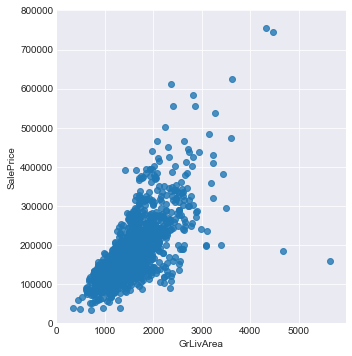

In [92]:
g = sns.lmplot("GrLivArea", "SalePrice", train, fit_reg=False)
g.set(ylim=(0, 800000))

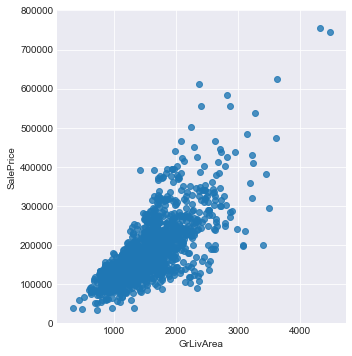

In [93]:
# delete two right lower points
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index, axis=0)
g = sns.lmplot("GrLivArea", "SalePrice", train, fit_reg=False)
g.set(ylim=(0, 800000))

### 1.2 Target Normalty

In [94]:
def normalty_plot(value):
    mu, sigma = ss.norm.fit(value)
    print("mu = %.2f  sigma = %.2f" % (mu, sigma))
    fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.distplot(value, fit=ss.norm, ax=axe[0])
    ss.probplot(value, plot=axe[1])
    fig.show()

mu = 180932.92  sigma = 79467.79


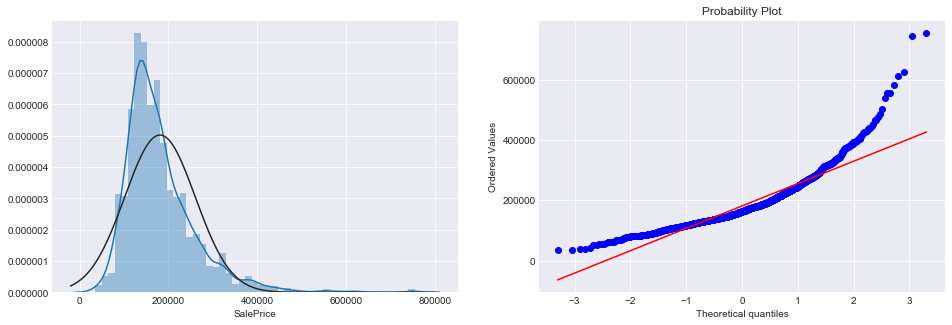

In [95]:
normalty_plot(train["SalePrice"])

mu = 12.02  sigma = 0.40


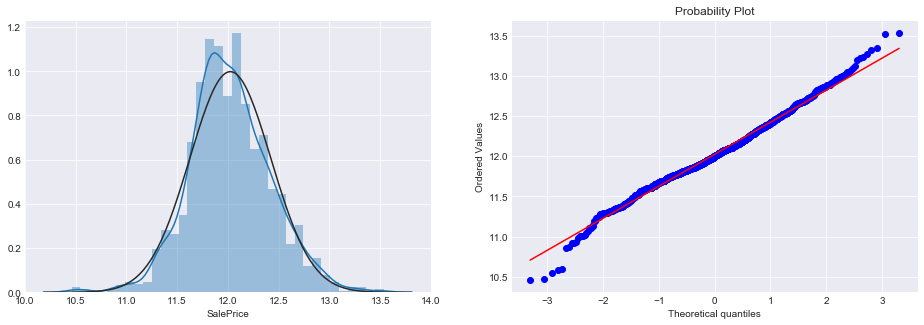

In [96]:
normalty_plot(np.log(train["SalePrice"]))

In [97]:
train["SalePrice"] = np.log1p(train["SalePrice"])  # x => log(1 + x)

### 1.3 Feature engineering

In [98]:
ntrain = len(train)
ntest = len(test)
y_train = train["SalePrice"].values
train_ids = train["Id"].values
test_ids = test["Id"].values
all_data = pd.concat([train.drop("SalePrice", axis=1), test], axis=0, ignore_index=True)
print("all data size: ", all_data.shape)

all data size:  (2917, 80)


#### 1.3.1 Missing Data

In [99]:
all_data_na = (all_data.isnull().sum() / len(all_data)).sort_values(ascending=False) * 100
missing_data = pd.DataFrame({"Missing Ratio": all_data_na[all_data_na > 0]})
missing_data[missing_data["Missing Ratio"] > 0]

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageCond,5.451
GarageQual,5.451
GarageYrBlt,5.451
GarageFinish,5.451


In [100]:
for col in ["MiscFeature", "Alley", "Fence", "FireplaceQu", 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            "MasVnrType"]:
    all_data[col] = all_data[col].fillna("None")

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
            "MasVnrArea"]:
    all_data[col] = all_data[col].fillna(0)

for col in ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"]:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].apply(lambda x: x.fillna(x.median()))
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# add features
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]
all_data["ISNeverRemodAdd"] = (all_data["YearRemodAdd"] == all_data["YearBuilt"]).astype(int)
all_data["AgeOfHouse"] = all_data["YrSold"] - all_data["YearBuilt"]
all_data["YrAfterRemodAdd"] = all_data["YrSold"] - all_data["YearRemodAdd"]
all_data = all_data.drop(["Utilities", "PoolArea", "PoolQC", "YearRemodAdd", "YearBuilt", "YrSold"], axis=1)
for col in ["MSSubClass", "MoSold"]:
    all_data[col] = all_data[col].astype(str)
    
print("Rest Missing Value: ", sum(all_data.isnull().sum()))

Rest Missing Value:  0


In [101]:
non_str_cols = []
non_str_unique_nums = []
for col in all_data.columns:
    if col == "Id":
        continue
    if all_data[col].dtype != "object":
        unique_num = all_data[col].nunique()
        non_str_cols.append(col)
        non_str_unique_nums.append(unique_num)
        
non_str_df = pd.DataFrame({"feature": non_str_cols, "unique_num": non_str_unique_nums})\
    .sort_values("unique_num", ascending=True)
print(non_str_df)
for col in non_str_df.query("unique_num < 30")["feature"]:
    non_str_cols.remove(col)
numerical_features = non_str_cols
print(numerical_features)

            feature  unique_num
31  ISNeverRemodAdd           2
16         HalfBath           3
14     BsmtHalfBath           3
18     KitchenAbvGr           4
13     BsmtFullBath           4
20       Fireplaces           5
15         FullBath           5
22       GarageCars           6
17     BedroomAbvGr           8
3       OverallCond           9
2       OverallQual          10
19     TotRmsAbvGrd          14
27        3SsnPorch          31
11     LowQualFinSF          36
29          MiscVal          38
33  YrAfterRemodAdd          63
21      GarageYrBlt         104
28      ScreenPorch         121
32       AgeOfHouse         128
0       LotFrontage         131
26    EnclosedPorch         183
25      OpenPorchSF         250
6        BsmtFinSF2         272
24       WoodDeckSF         379
4        MasVnrArea         442
23       GarageArea         602
10         2ndFlrSF         633
5        BsmtFinSF1         989
8       TotalBsmtSF        1056
9          1stFlrSF        1081
7       

#### 1.3.2 Feature Corr

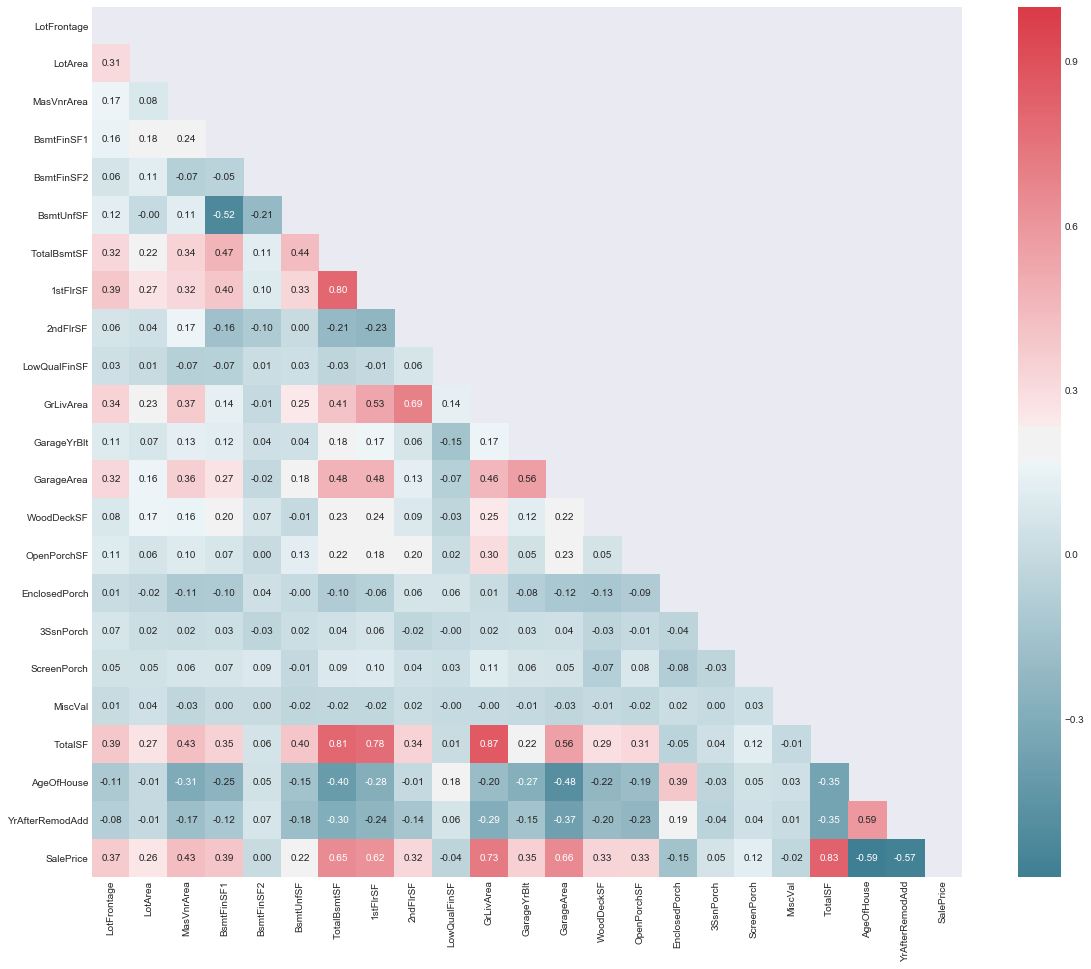

In [102]:
fig, axe = plt.subplots(figsize=(20, 16))
df = pd.concat([all_data[np.isin(all_data["Id"], train_ids)], pd.DataFrame({"SalePrice": y_train})], axis=1)
corrmat = df[numerical_features + ["SalePrice"]].corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)
g = sns.heatmap(corrmat, mask=mask, cmap=cmap, square=True, annot=True, fmt="0.2f", ax=axe)
fig.show()

#### 1.3.3 Categorical Features to_numerical

In [103]:
# order-meanningful categorical features
dummy_dict = {}
dummy_dict["LotShape"] = {"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}
dummy_dict["LandSlope"] = {"Gtl": 2, "Mod": 1, "Sev": 0}
dummy_dict["ExterQual"] = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
dummy_dict["ExterCond"] = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
dummy_dict["BsmtQual"] = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
dummy_dict["BsmtCond"] = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
dummy_dict["BsmtExposure"] = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0}
dummy_dict["BsmtFinType1"] = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0}
dummy_dict["BsmtFinType2"] = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0}
dummy_dict["HeatingQC"] = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
dummy_dict["KitchenQual"] = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}
dummy_dict["Functional"] = {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}
dummy_dict["FireplaceQu"] = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
dummy_dict["GarageFinish"] = {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0}
dummy_dict["GarageQual"] = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
dummy_dict["GarageCond"] = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
dummy_dict["PoolQC"] = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "None": 0}
dummy_dict["Fence"] = {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "None": 0}
dummy_dict["PavedDrive"] = {"Y": 2, "P": 1, "N": 0}
dummy_dict["CentralAir"] = {"Y": 1, "N": 0}

for col, m in dummy_dict.items():
    try:
        all_data[col] = all_data[col].map(m)
    except KeyError:
        pass
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head(5)

(2917, 248)


,Id,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.000,8450,3,2,7,5,196.000,3,2,...,0,0,0,1,0,0,0,0,1,0
1,2,80.000,9600,3,2,6,8,0.000,2,2,...,0,0,0,1,0,0,0,0,1,0
2,3,68.000,11250,2,2,7,5,162.000,3,2,...,0,0,0,1,0,0,0,0,1,0
3,4,60.000,9550,2,2,7,5,0.000,2,2,...,0,0,0,1,1,0,0,0,0,0
4,5,84.000,14260,2,2,8,5,350.000,3,2,...,0,0,0,1,0,0,0,0,1,0


#### 1.3.4 Skewed Features Fix

In [104]:
skewed_features = all_data[numerical_features].apply(lambda x: x.skew(), axis=0).sort_values(ascending=False)
skewness = pd.DataFrame({"Skew": skewed_features})
skewness.head(10)

,Skew
MiscVal,21.951
LotArea,13.116
LowQualFinSF,12.091
3SsnPorch,11.378
BsmtFinSF2,4.147
EnclosedPorch,4.004
ScreenPorch,3.947
MasVnrArea,2.623
OpenPorchSF,2.531
WoodDeckSF,1.846


mu = 50.86  sigma = 567.50
mu = 10139.44  sigma = 7805.70
mu = 4.70  sigma = 46.40
mu = 2.60  sigma = 25.19
mu = 49.60  sigma = 169.20
mu = 23.11  sigma = 64.25
mu = 16.07  sigma = 56.19
mu = 100.93  sigma = 178.00
mu = 47.28  sigma = 67.11
mu = 93.63  sigma = 126.51


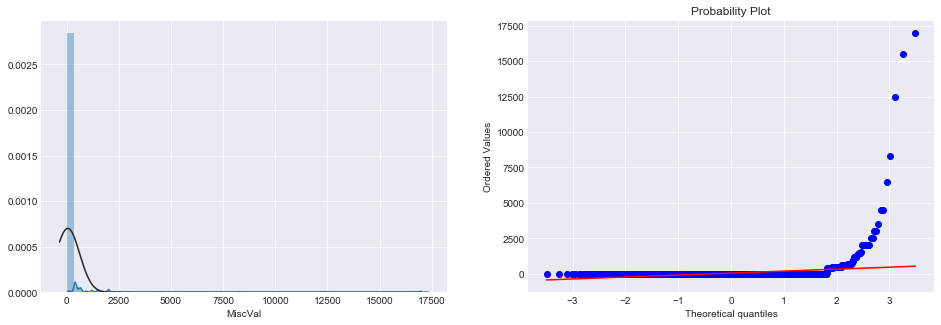

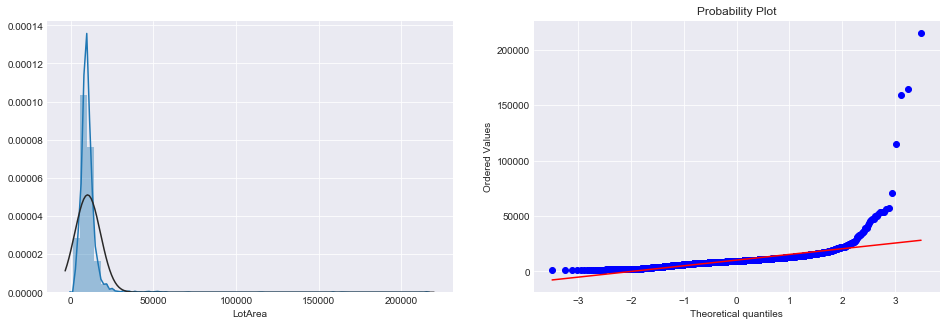

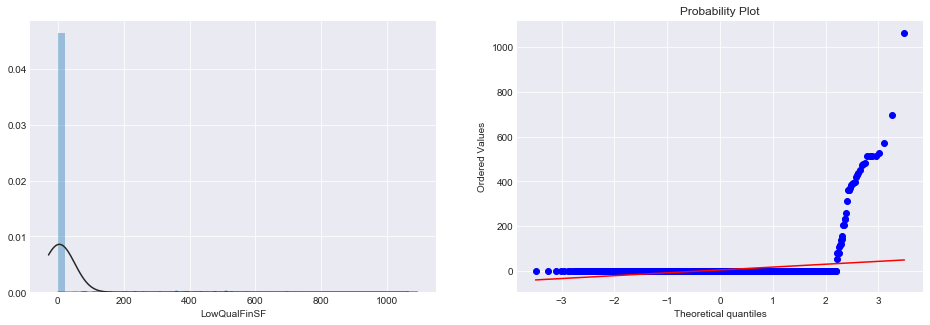

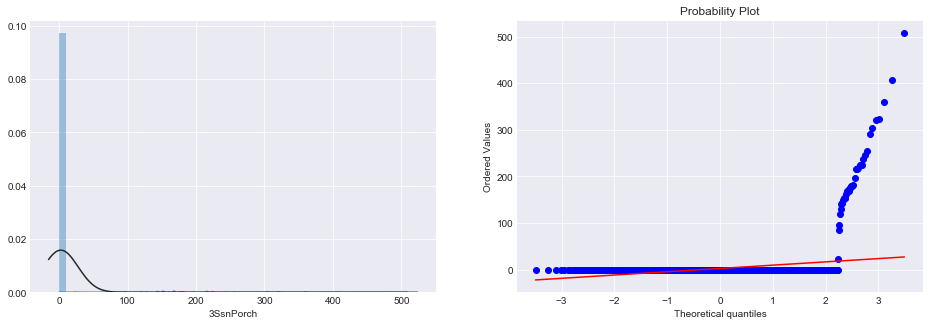

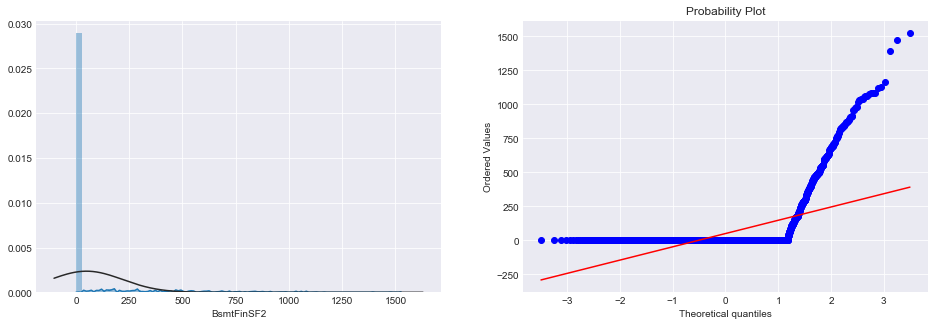

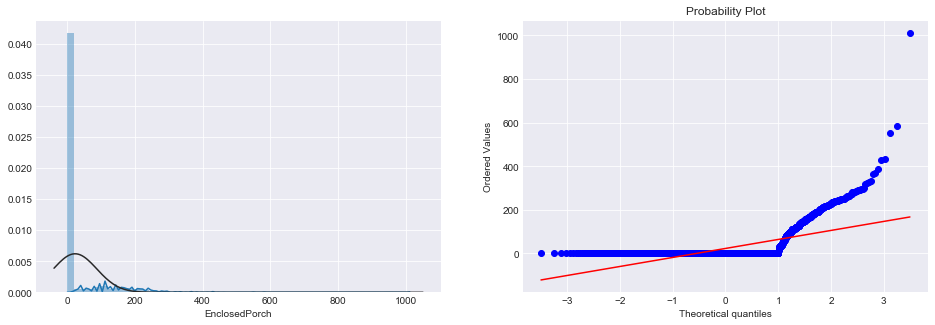

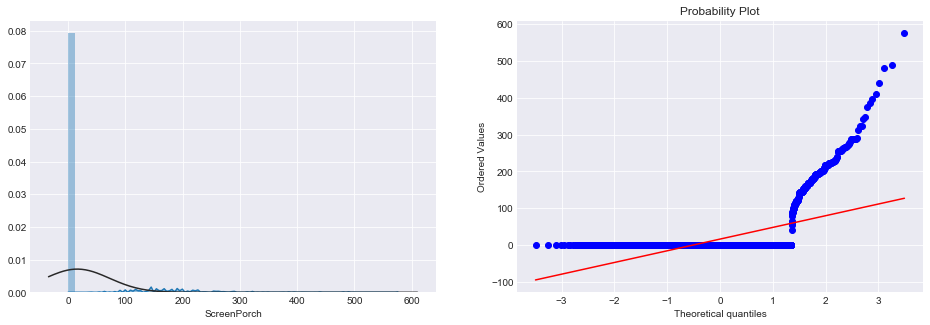

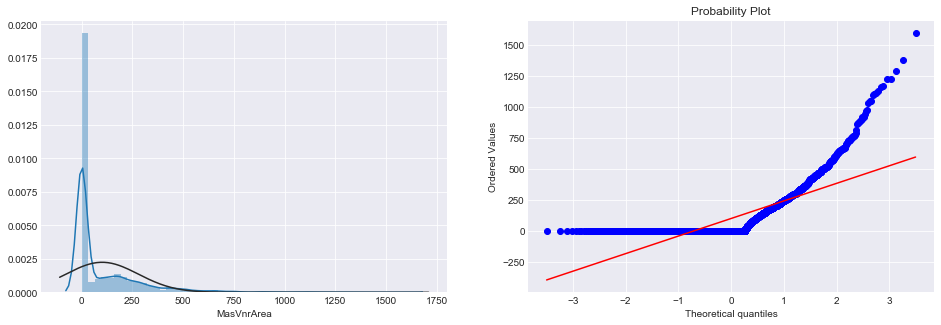

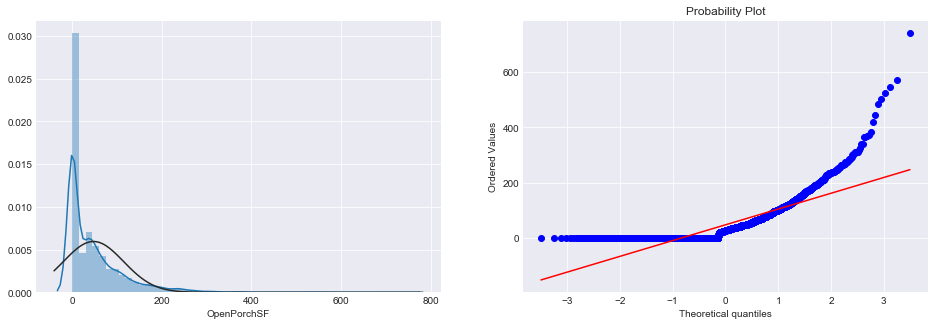

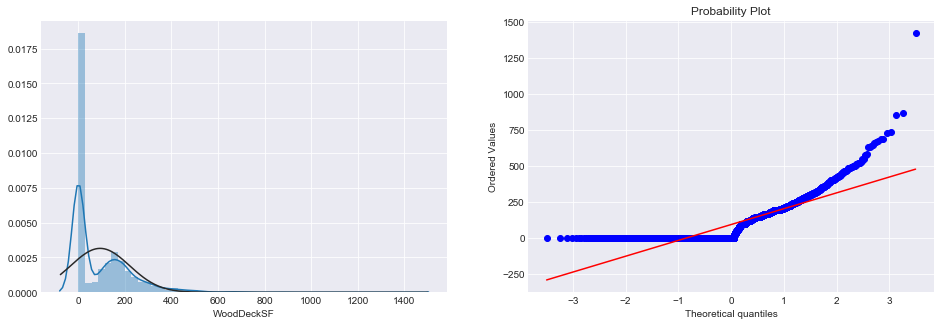

In [105]:
for col in skewness[:10].index.values:
    normalty_plot(all_data[col])

There are 18 skewed numerical features to Box-cox transform
mu = 0.41  sigma = 2.21
mu = 19.49  sigma = 1.97
mu = 0.12  sigma = 1.05
mu = 0.10  sigma = 0.90
mu = 1.10  sigma = 3.06
mu = 1.12  sigma = 2.64
mu = 0.68  sigma = 2.21
mu = 3.20  sigma = 4.11
mu = 3.29  sigma = 3.11
mu = 3.71  sigma = 3.97
mu = 12.42  sigma = 0.92
mu = 5.88  sigma = 0.60
mu = 13.17  sigma = 0.96
mu = 14.82  sigma = 0.99
mu = 7.06  sigma = 5.12
mu = 9.34  sigma = 3.41
mu = 4.84  sigma = 5.63
mu = 13.38  sigma = 3.21


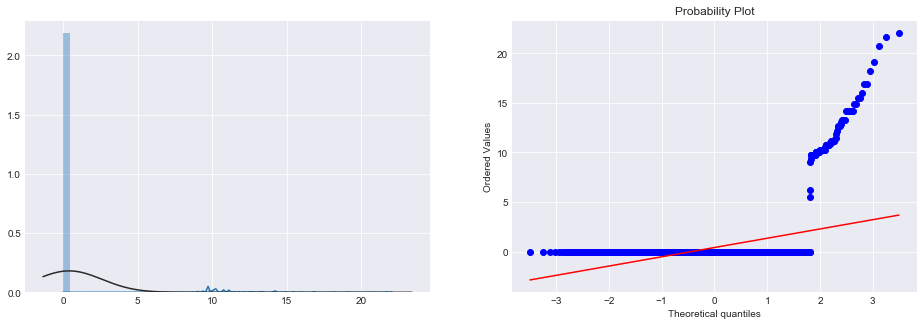

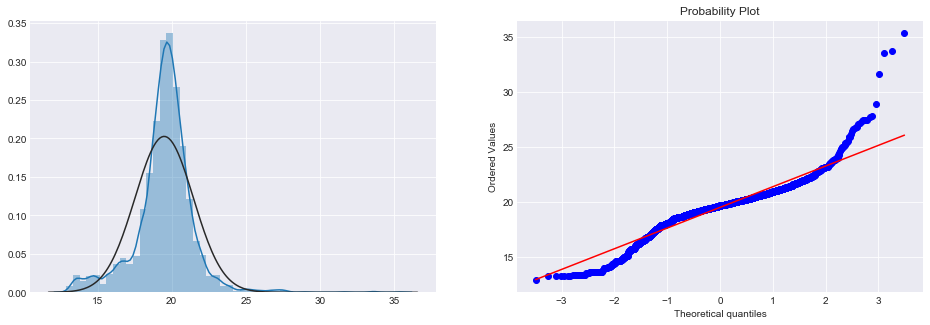

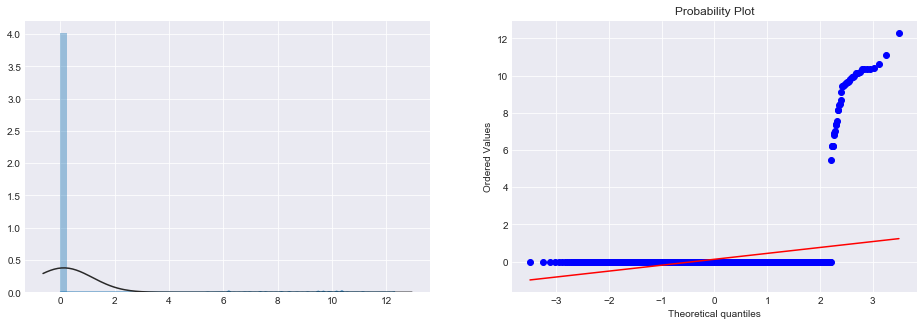

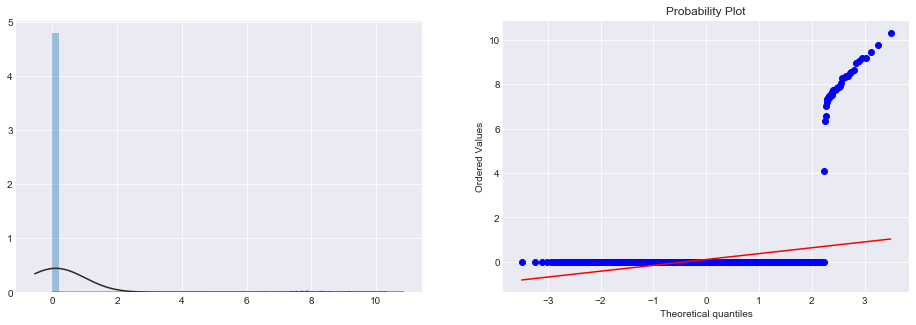

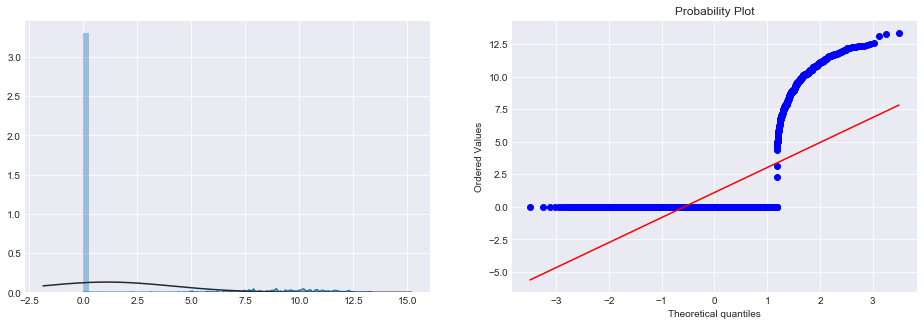

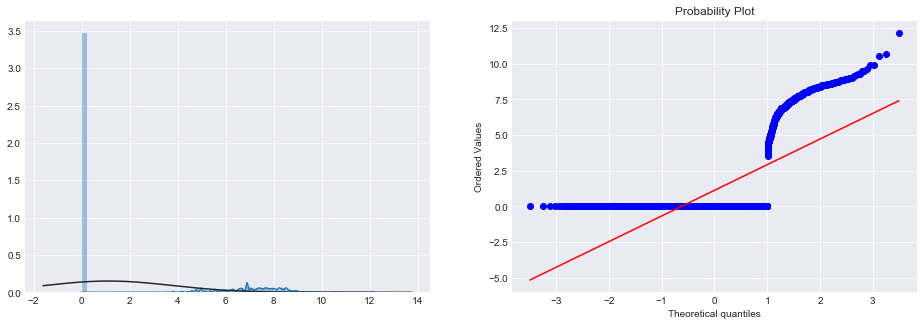

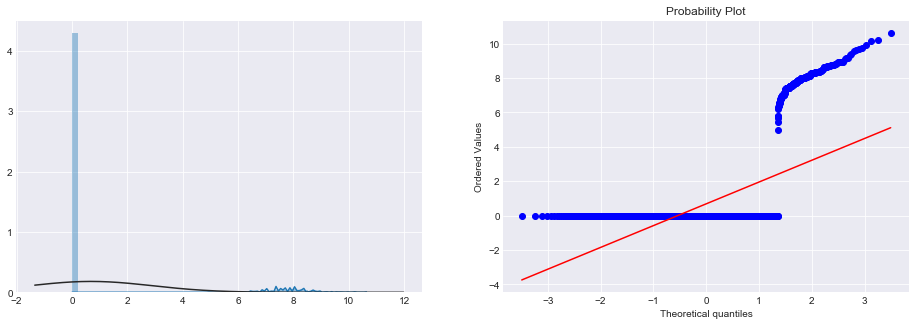

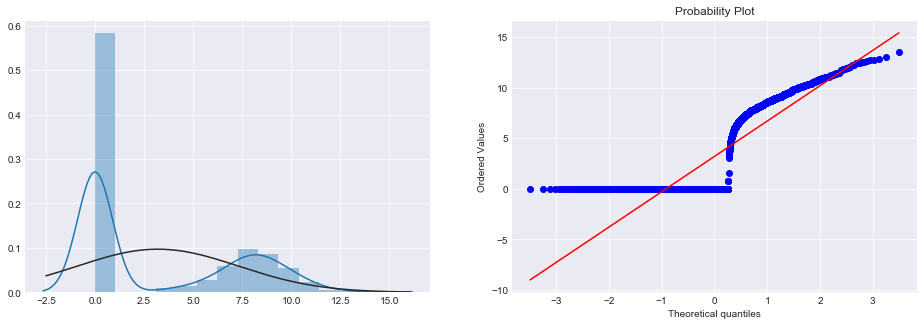

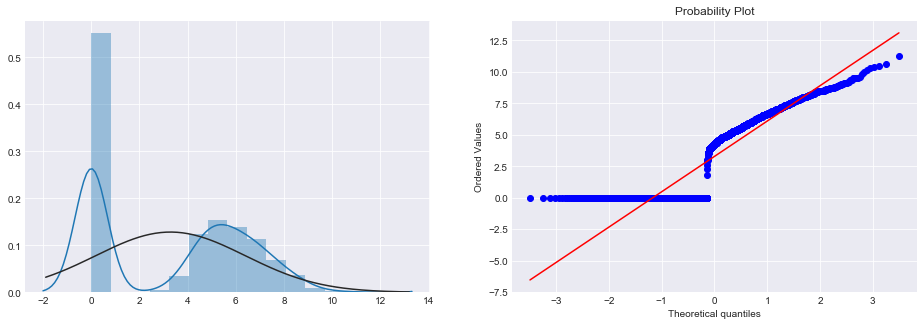

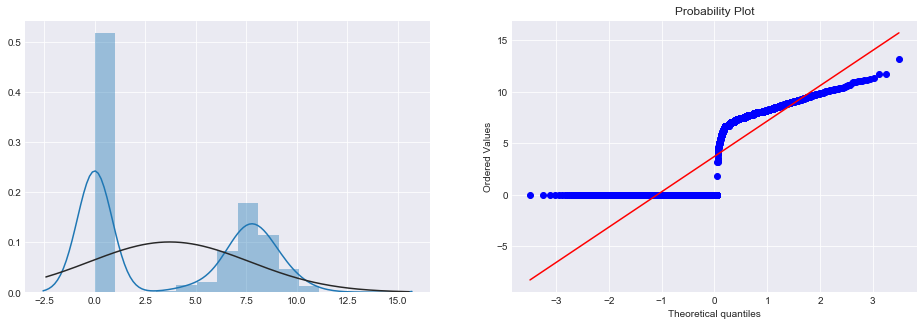

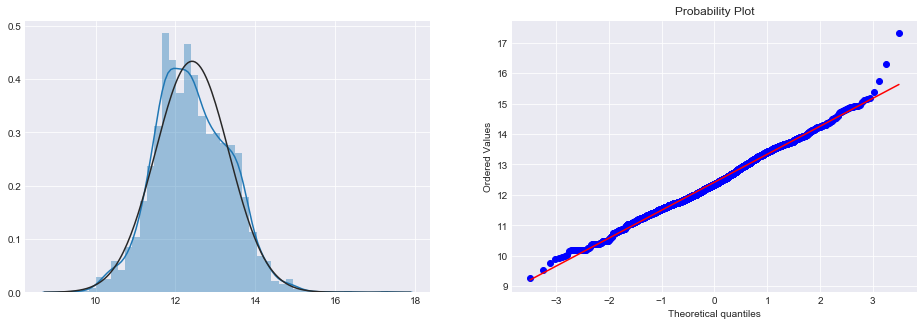

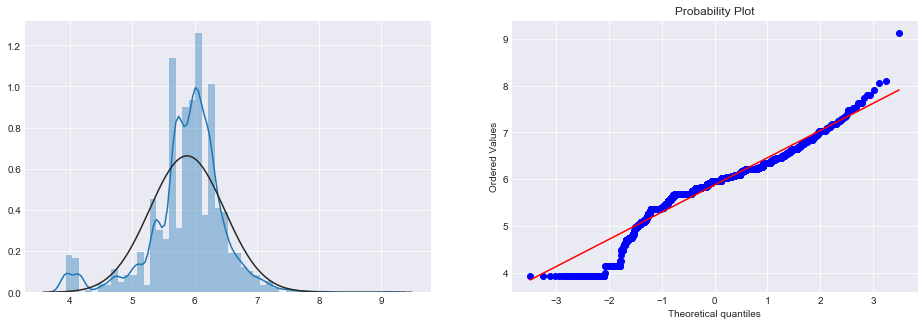

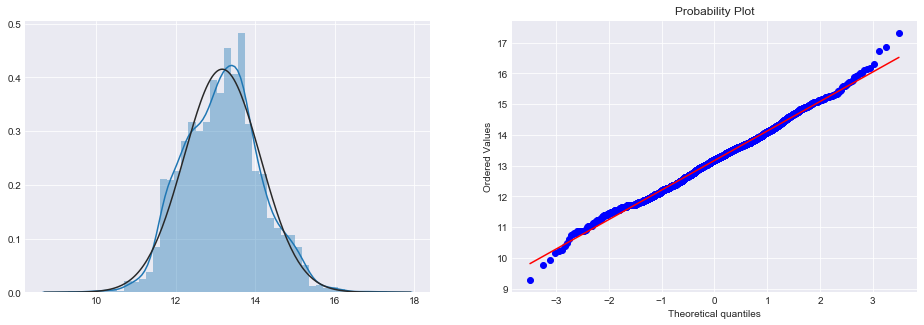

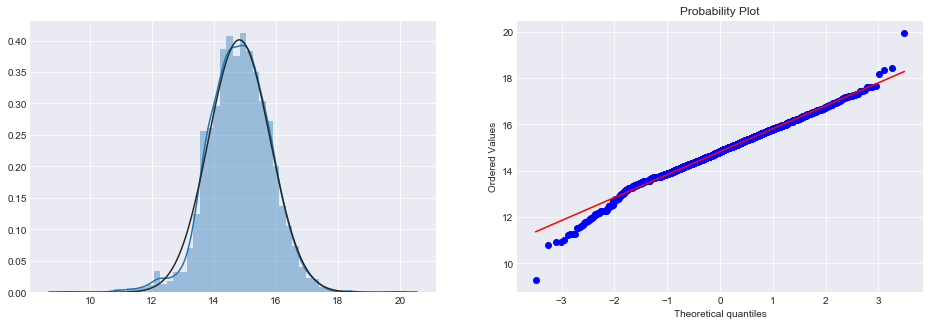

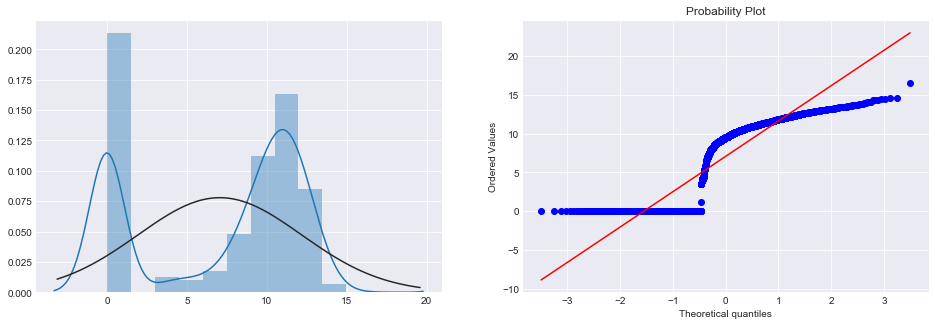

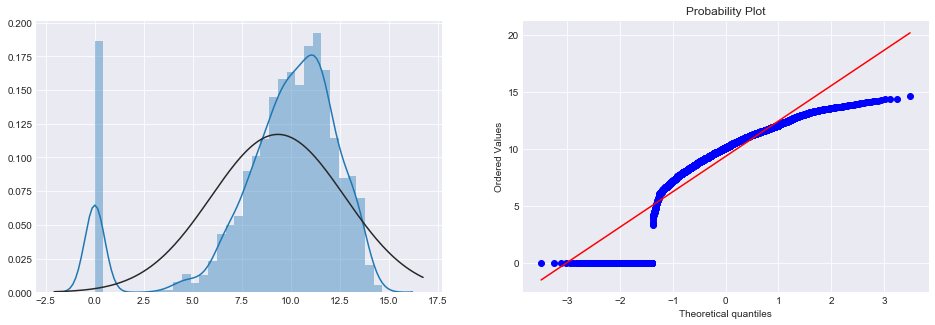

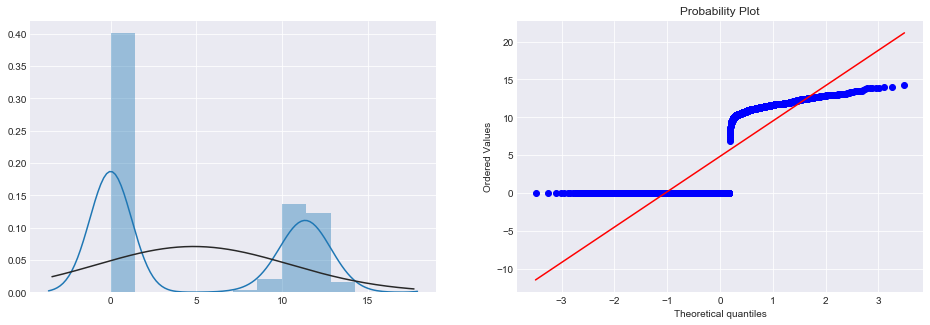

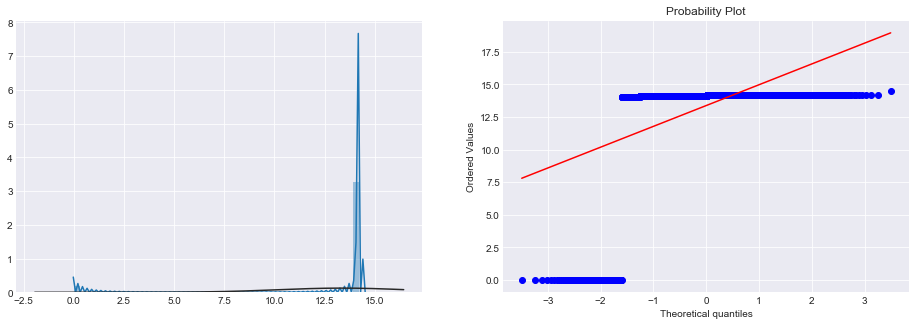

In [106]:
target = skewed_features[abs(skewed_features) > 0.75].index.tolist()
print("There are %d skewed numerical features to Box-cox transform" % len(target))

lam = 0.15
for col in target:
    transformed = ss.boxcox(all_data[col] + 1, lmbda=lam)
    normalty_plot(transformed)
    all_data[col] = transformed

## 2. Modeling

In [107]:
train = all_data[np.isin(all_data["Id"], train_ids)].drop("Id", axis=1)
test = all_data[np.isin(all_data["Id"], test_ids)].drop("Id", axis=1)

In [108]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

### 2.1 Base Models

**Defines a cv strategy**

In [132]:
n_folds = 5
def rmse_cv(model):
    X = train.values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0).get_n_splits(X)
    rmse = np.sqrt(-1 * cross_val_score(estimator=model, X=X, y=y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

**Base Models**

In [135]:
base_models = {}
# This model may be very sensitive to outliers. 
# So we need to made it more robust on them. 
# For that we use the sklearn's Robustscaler() method on pipeline
base_models["lasso"] = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=0))
base_models["eNet"] = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=0))

base_models["kernelRidge"] = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)

# With huber loss that makes it robust to outliers
base_models["gbdt"] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                                max_features="sqrt", min_samples_leaf=15, min_samples_split=10, 
                                                loss="huber", random_state=0)

base_models["xgb"] = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, 
                                      max_depth=3, min_child_weight=1.7817, n_estimators=2200, 
                                      reg_alpha=0.464, reg_lambda=0.8571, subsample=0.5213, 
                                      silent=True, random_state=0, nthread=-1)
base_models["lgbm"] = lgb.LGBMRegressor(objective="regression", num_leaves=5, learning_rate=0.05, 
                                        n_estimators=720, max_bin=55, 
                                        bagging_fraction=0.8, bagging_freq=5, bagging_seed=0, 
                                        feature_fraction=0.2319, feature_fraction_seed=0, 
                                        min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

**Base models scores**

In [137]:
for name, model in base_models.items():
    scores = rmse_cv(model)
    mean = scores.mean()
    std = scores.std()
    print("%s: %.4f (%.4f)" % (name, mean, std))

lasso: 0.1100 (0.0046)
eNet: 0.1100 (0.0046)
kernelRidge: 0.1786 (0.0080)
gbdt: 0.1142 (0.0060)
xgb: 0.1155 (0.0059)
lgbm: 0.1155 (0.0049)


### 2.2 Stacking Models

#### 2.2.1 Averaging base models

In [138]:
class AvgModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        # make a copy from untrained models
        self.models_ = [clone(x) for x in self.models]
        
        # train cloned base models
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [139]:
# test on avg_model
avg_model = AvgModels(models=[base_models[x] for x in ["eNet", "gbdt", "kernelRidge", "lasso"]])
scores = rmse_cv(avg_model)
mean = scores.mean()
std = scores.std()
print("Averaged model: %.4f (%.4f)" % (mean, std))

Averaged model: 0.1133 (0.0042)


#### 2.2.2 Stacking

In [140]:
class StackingAvgModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for model in self.base_models]  # 容器，保存每个fold的训练模型 [n_fold, n_model]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=0)
        
        out_of_fold_predictions = np.zeros((len(X), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_indexes, test_indexes in kfold.split(X, y):
                instance = clone(model)
                instance.fit(X[train_indexes], y[train_indexes])
                self.base_models_[i].append(instance)
                out_of_fold_predictions[test_indexes, i] = instance.predict(X[test_indexes])
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

In [141]:
# test on Stacking model
stacked_avg_models = StackingAvgModels(
    base_models=[base_models[x] for x in ["eNet", "gbdt", "kernelRidge"]],
    meta_model=base_models["lasso"]
)
scores = rmse_cv(stacked_avg_models)
mean = scores.mean()
std = scores.std()
print("Stacked model: %.4f (%.4f)" % (mean, std))

Stacked model: 0.1069 (0.0050)


### 2.3 Ensembling StackedRegressor, XGBoost and LightGBM

In [142]:
models = {}
models["stack"] = clone(stacked_avg_models)
models["xgb"] = clone(base_models["xgb"])
models["lgbm"] = clone(base_models["lgbm"])

In [143]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def ensemble(pred_dic, coef_dic):
    return np.sum(np.column_stack([
        weight * pred_dic[name] 
        for name, weight in coef_dic.items()
    ]), axis=1)   

In [144]:
train_preds = {}
test_preds = {}
for name, model in models.items():
    model.fit(train.values, y_train)
    train_pred = model.predict(train.values)
    train_preds[name] = train_pred
    # don't forget transform inversedly back
    test_preds[name] = np.expm1(model.predict(test.values))  # x => exp(x) - 1  inverse function of log1p
    train_score = rmse(y_train, train_pred)
    print("%s train_score: %.4f" % (name, train_score))    

stack train_score: 0.0757
xgb train_score: 0.0797
lgbm train_score: 0.0733


In [145]:
ensemble_coef = {"stack": 0.7, "xgb": 0.15, "lgbm": 0.15}
ensemble_train_pred = ensemble(train_preds, ensemble_coef)
print(rmse(y_train, ensemble_train_pred))

0.0740279880543928


In [146]:
ensemble_test_pred = ensemble(test_preds, ensemble_coef)
sub = pd.DataFrame({"Id": test_ids, "SalePrice": ensemble_test_pred})
sub.to_csv(path + "submission.csv", index=False)